In [2]:
%matplotlib notebook
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import astropy.io.fits as pf
from astropy.stats import mad_std
from astropy.visualization import ZScaleInterval
import ccdproc as ccdp
from astropy import units as u

from astropy.nddata import CCDData
from iraf_um import imstat, inv_median

import warnings
from astropy.utils.exceptions import AstropyWarning

import astroalign as aa
from copy import deepcopy

***Path***

In [3]:
path = 'E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/'

path_dict = { 'bias' : '2024-09-23-lyon-mtp/bias/', 'flat_r' : '2024-09-24-lyon-mtp/flat/filtre_r/', 'flat_g' : '2024-09-24-lyon-mtp/flat/filtre_g/',
              'dark' : '2024-09-23-lyon-mtp/dark/', 'baseline_23' : '2024-09-23-lyon-mtp/baseline/', 'baseline_24' : '2024-09-24-lyon-mtp/baseline/',
              'obs_sec_r' : '2024-09-23-lyon-mtp/observation_secondaire/', 'obs_sec_g' : '2024-09-24-lyon-mtp/observation_secondaire/',
              'obs_pri_r' : '2024-09-24-lyon-mtp/observation_primaire/', 'baseline_23_t' : '2024-09-23-lyon-mtp_t/baseline/' , 
              'baseline_24_t' : '2024-09-24-lyon-mtp_t/baseline/', 'obs_sec_r_t' : '2024-09-23-lyon-mtp_t/observation_secondaire/',
              'obs_sec_g_t' : '2024-09-24-lyon-mtp_t/observation_secondaire/', 'obs_pri_r_t' : '2024-09-24-lyon-mtp_t/observation_primaire/', 
              'baseline_23_c' : '2024-09-23-lyon-mtp_c/baseline/' , 'baseline_24_c' : '2024-09-24-lyon-mtp_c/baseline/',
              'obs_sec_r_c' : '2024-09-23-lyon-mtp_c/observation_secondaire/', 'obs_sec_g_c' : '2024-09-24-lyon-mtp_c/observation_secondaire/',
              'obs_pri_r_c' : '2024-09-24-lyon-mtp_c/observation_primaire/' }

print(path+path_dict['bias'])

E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-23-lyon-mtp/bias/


***CCD Char***

In [7]:
ccd_gain = 1.47 * u.electron / u.adu
ccd_ron = 11 * u.electron

***Master bias***

In [8]:
ifc_raw = ccdp.ImageFileCollection(path+path_dict['bias'])
ifc_bias = ifc_raw.filter(imagetyp='Bias Frame')
warnings.filterwarnings("ignore", category=AstropyWarning)
master_bias = ccdp.combine(ifc_bias.files_filtered(include_path=True), unit='adu', combine='average', mem_limit=9000.e6)
warnings.filterwarnings("default")
master_bias.meta['COMBINED'] = True
master_bias.write(path+'master_bias.fit', hdu_mask=None, hdu_uncertainty=None, overwrite=True)

***Master flat***

In [9]:
ifc_raw = [ ccdp.ImageFileCollection(path+path_dict['flat_r']), ccdp.ImageFileCollection(path+path_dict['flat_g']) ]
ifc_flatH = [ ifc_raw[0].filter(imagetyp='Flat Field'), ifc_raw[1].filter(imagetyp='Flat Field') ]
master_flatH = [None,None]
for i in range(len(ifc_flatH)):
    warnings.filterwarnings("ignore", category=AstropyWarning)
    master_flatH[i] = ccdp.combine(ifc_flatH[i].files_filtered(include_path=True), unit='adu', combine='average', mem_limit=9000.e6)
    warnings.filterwarnings("default")
    master_flatH[i].meta['COMBINED'] = True
    master_flatH[i] = ccdp.subtract_bias(master_flatH[i], master_bias)

master_flatH[0].write(path + 'master_flatH_r.fit', hdu_mask=None, hdu_uncertainty=None, overwrite=True)
master_flatH[1].write(path + 'master_flatH_g.fit', hdu_mask=None, hdu_uncertainty=None, overwrite=True)

***Master dark***

In [10]:
ifc_raw = ccdp.ImageFileCollection(path+path_dict['dark'])
ifc_dark = ifc_raw.filter()
warnings.filterwarnings("ignore", category=AstropyWarning)
master_dark = ccdp.combine(ifc_dark.files_filtered(include_path=True), unit='adu', combine='average', mem_limit=9000.e6)
warnings.filterwarnings("default")
master_dark.meta['COMBINED'] = True
master_dark.write(path+'master_dark.fit', hdu_mask=None, hdu_uncertainty=None, overwrite=True)

In [11]:
warnings.filterwarnings("ignore", category=AstropyWarning)
master_bias = ccdp.CCDData.read(path + 'master_bias.fit', unit='adu')
master_bias.to_hdu().info()
print('\n')
master_flatH_g = ccdp.CCDData.read(path + 'master_flatH_g.fit', unit='adu')
master_flatH_g.to_hdu().info()
print('\n')
master_flatH_r = ccdp.CCDData.read(path + 'master_flatH_r.fit', unit='adu')
master_flatH_r.to_hdu().info()
print('\n')
master_dark = ccdp.CCDData.read(path+'master_dark.fit', unit='adu')
master_flatH_r.to_hdu().info()
warnings.filterwarnings("default")

INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      37   (3072, 2047)   float64   


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.




INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      40   (3072, 2047)   float64   


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.




INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      40   (3072, 2047)   float64   


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.




INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      40   (3072, 2047)   float64   


***Traitement image***

In [7]:
input = ['baseline_23', 'baseline_24', 'obs_sec_r', 'obs_sec_g','obs_pri_r' ]
output = ['baseline_23_t', 'baseline_24_t', 'obs_sec_r_t', 'obs_sec_g_t','obs_pri_r_t' ]
for collection in input:
    ifc_raw = ccdp.ImageFileCollection(path+path_dict[collection])
    ifc_sci = ifc_raw.filter(imagetyp='Light Frame')
    for image in ifc_sci.summary['file']:
        warnings.filterwarnings("ignore", category=AstropyWarning)
        name = os.path.split(path+path_dict[collection]+image)[1]
        print(path+path_dict[output[input.index(collection)]])
        ccd_sci = ccdp.CCDData.read(image, unit='adu')
        ccd_sci_b = ccdp.subtract_bias(ccd_sci, master_bias)
        ccd_sci_bf = ccdp.flat_correct(ccd_sci_b, master_flatH_r)
        ccd_sci_bfd = ccdp.subtract_dark(ccd_sci_bf, master_dark, exposure_time=10, exposure_unit=u.second)
        ccd_sci_bfdg = ccdp.gain_correct(ccd_sci_bfd, ccd_gain)
        ccd_sci_bfdg.data = np.clip(ccd_sci_bfdg.data, 0, np.iinfo(np.int16).max).astype('int16')
        ccd_sci_bfdg.write(path+path_dict[output[input.index(collection)]]+name, overwrite=True)
        warnings.filterwarnings("default")

E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-23-lyon-mtp_t/baseline/


KeyboardInterrupt: 

In [13]:
input = ['baseline_23', 'baseline_24', 'obs_sec_r', 'obs_sec_g','obs_pri_r' ]
output = ['baseline_23_t', 'baseline_24_t', 'obs_sec_r_t', 'obs_sec_g_t','obs_pri_r_t' ]

collection = 'baseline_23'

ifc_raw = ccdp.ImageFileCollection(path+path_dict[collection])
ifc_sci = ifc_raw.filter(imagetyp='Light Frame')
for image in ifc_sci.summary['file']:
    warnings.filterwarnings("ignore", category=AstropyWarning)
    name = os.path.split(path+path_dict[collection]+image)[1]
    print(path+path_dict[output[input.index(collection)]]+name)
    ccd_sci = ccdp.CCDData.read(image, unit='adu')
    ccd_sci_b = ccdp.subtract_bias(ccd_sci, master_bias)
    ccd_sci_bf = ccdp.flat_correct(ccd_sci_b, master_flatH_r)
    ccd_sci_bfd = ccdp.subtract_dark(ccd_sci_bf, master_dark, exposure_time=10, exposure_unit=u.second)
    ccd_sci_bfdg = ccdp.gain_correct(ccd_sci_bfd, ccd_gain)
    ccd_sci_bfdg.write(path+path_dict[output[input.index(collection)]]+name, overwrite=True)
    warnings.filterwarnings("default")

E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-23-lyon-mtp_t/baseline/baseline-0001r.fit
E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-23-lyon-mtp_t/baseline/baseline-0002r.fit
E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-23-lyon-mtp_t/baseline/baseline-0003r.fit
E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-23-lyon-mtp_t/baseline/baseline-0004r.fit
E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-23-lyon-mtp_t/baseline/baseline-0005r.fit
E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-23-lyon-mtp_t/baseline/baseline-0006r.fit
E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-23-lyon-mtp_t/baseline/baseline-0007r.fit
E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-23-lyon-mtp_t/baseline/baseline-0008r.fit
E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-23-lyon-mtp_t/baseline/baseline-0009r.fit
E:/Documents/Cours_

***recentrer***

In [ ]:
input = ['baseline_23_t', 'baseline_24_t', 'obs_sec_r_t', 'obs_sec_g_t', 'obs_pri_r_t']
output = ['baseline_23_c', 'baseline_24_c', 'obs_sec_r_c', 'obs_sec_g_c', 'obs_pri_r_c']

In [19]:
import os
import gc
import warnings
import astroalign as aa
import numpy as np
from astropy.nddata import CCDData
from ccdproc import ImageFileCollection
from astropy.utils.exceptions import AstropyWarning
from copy import deepcopy

input = ['obs_sec_g_t']
output = ['obs_sec_g_c']

for collection in input:
    names = []
    ifc_raw = ImageFileCollection(path + path_dict[collection])
    ifc_sci = ifc_raw.filter(imagetyp='Light Frame')

    # Set the reference image from the first one
    first_image_path = ifc_sci.summary['file'][0]
    reference_image = CCDData.read(first_image_path, unit='adu')
    reference_data_little_endian = reference_image.data.astype('<f8')
    names.append(os.path.split(first_image_path)[1])

    print(f"Loaded reference image: {names[0]}")

    # Write the first image to the output path
    output_path = path + path_dict[output[input.index(collection)]] + os.path.split(first_image_path)[1]
    reference_image.write(output_path, overwrite=True)  # Save the first image

    # Loop through the rest of the images
    for i, image in enumerate(ifc_sci.summary['file'][1:], start=1):
        image_path = image
        try:
            ccd_sci = CCDData.read(image_path, unit='adu')
            ccd_data_little_endian = ccd_sci.data.astype('<f8')

            # Find transformation with astroalign
            p, (pos_img, pos_img_rot) = aa.find_transform(ccd_data_little_endian, reference_data_little_endian, detection_sigma=15, min_area=40)

            print(f"Image #{i} aligned to reference frame")
            print("Rotation: {:.2f} degrees".format(p.rotation * 180.0 / np.pi))
            print("Scale factor: {:.2f}".format(p.scale))
            print("Translation: (x, y) = ({:.2f}, {:.2f})".format(*p.translation))

            # Apply the transformation
            img_aligned, footprint = aa.apply_transform(p, ccd_data_little_endian, reference_data_little_endian)

            # Update ccd_sci with the new aligned data
            ccd_sci.data = img_aligned

            # Write the aligned image to the output path
            output_path = path + path_dict[output[input.index(collection)]] + os.path.split(image_path)[1]
            ccd_sci.write(output_path, overwrite=True)

            # Update the reference image
            reference_data_little_endian = img_aligned

        except Exception as e:
            print(f"Error aligning image #{i}: {e}")
            continue

        print(f"Processed and saved image: {image}")

        # Clear memory explicitly and run garbage collection
        del ccd_sci, ccd_data_little_endian, img_aligned, footprint
        gc.collect()  # Force garbage collection to free memory


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]


Loaded reference image: obs_sec-0001g.fit


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #1 aligned to reference frame
Rotation: -0.02 degrees
Scale factor: 1.00
Translation: (x, y) = (1.12, 2.69)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Processed and saved image: E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_t/observation_secondaire/obs_sec-0002g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #2 aligned to reference frame
Rotation: -0.04 degrees
Scale factor: 1.00
Translation: (x, y) = (7.86, 1.84)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Processed and saved image: E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_t/observation_secondaire/obs_sec-0003g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #3 aligned to reference frame
Rotation: -0.03 degrees
Scale factor: 1.00
Translation: (x, y) = (4.41, 0.62)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Processed and saved image: E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_t/observation_secondaire/obs_sec-0004g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #4 aligned to reference frame
Rotation: -0.05 degrees
Scale factor: 1.00
Translation: (x, y) = (1.44, -0.15)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit electron in the FITS file.


Processed and saved image: E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_t/observation_secondaire/obs_sec-0005g.fit
INFO: using the unit adu passed to the FITS reader instead of the unit electron in the FITS file. [astropy.nddata.ccddata]
Image #5 aligned to reference frame
Rotation: -0.03 degrees
Scale factor: 1.00
Translation: (x, y) = (5.26, -0.66)


KeyboardInterrupt: 

In [32]:
# import and settings
import numpy as np
import matplotlib.pyplot as plt
import ccdproc as ccdp
import os

from astropy.visualization import ZScaleInterval
from astropy.io import fits
from astropy.nddata import CCDData
from astropy.coordinates import SkyCoord
from photutils.aperture import CircularAperture, aperture_photometry, CircularAnnulus
from photutils.detection import DAOStarFinder
from astropy.stats import mad_std
from scipy.ndimage import shift

In [44]:
## Chargement des donnees
# Fonction pour lister tous les fichiers .fit et .fits dans un dossier donné

def list_fits_files(folder):
    return [os.path.join(folder, f) for f in os.listdir(folder) if f.endswith(('.fit', '.fits'))]
# Dossier contenant les fichiers FITS
folder_path = path + path_dict['obs_pri_r_c']

# Lister tous les fichiers .fits dans le dossier
fits_files = list_fits_files(folder_path)


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
-1541.885043874777 -1545.3600980438773 11.593151921508735
 id xcentroid ycentroid sharpness   roundness1   roundness2  npix    peak      flux       mag      daofind_mag 
--- --------- --------- ---------- ------------ ------------ ---- --------- ---------- ---------- -------------
  1 298.37867  69.42656  0.4171236  0.092613224  -0.16832635  169 13.216315  295.47611 -6.1763059  -0.054378134
  2 2602.8537 109.96593 0.51436239   0.11540433  -0.14121452  169 31.616797  410.97302 -6.5345333    -0.8059348
  3 2071.8432 290.93785 0.45977402  0.039340918  -0.21198733  169 1447.5706  194942.67 -13.224767     -3.265756
  4 2013.4162 534.90775 0.39870055  -0.29730558   0.29287804  169 6.6933627 -499.94942        nan -0.0065747796
  5 2736.6759 589.62199  0.4469708  0.017910091 -0.063065946  169 43.176579  946.42734 -7.4402182     -1.217523
  6 1011.2159 609.17166 0.77903488  -0.3

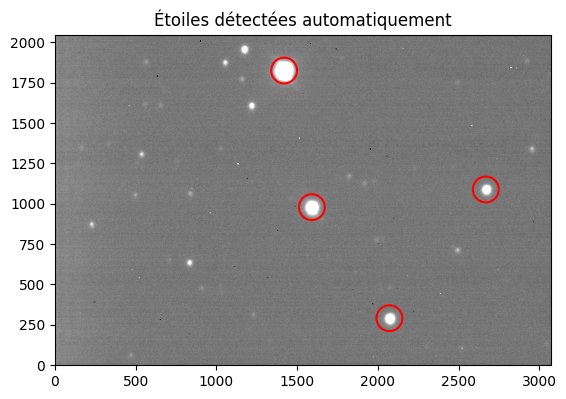

Étoile 1:  id xcentroid ycentroid sharpness  roundness1  roundness2 npix    peak      flux      mag    daofind_mag
--- --------- --------- ---------- ---------- ----------- ---- --------- --------- --------- -----------
 20 1419.5196 1824.8863 0.35589644 0.20009805 0.020949222  169 19592.509 2763095.7 -16.10349  -6.0910292
Étoile 2:  id xcentroid ycentroid sharpness  roundness1  roundness2 npix   peak      flux      mag     daofind_mag
--- --------- --------- ---------- ---------- ----------- ---- -------- --------- ---------- -----------
 13 1591.2973 978.88315 0.41669598 0.20508955 0.070373257  169 4834.904 649985.05 -14.532258  -4.6897735
Étoile 3:  id xcentroid ycentroid sharpness   roundness1  roundness2 npix    peak      flux      mag     daofind_mag
--- --------- --------- ---------- ----------- ----------- ---- --------- --------- ---------- -----------
  3 2071.8432 290.93785 0.45977402 0.039340918 -0.21198733  169 1447.5706 194942.67 -13.224767   -3.265756
Étoile 4:  id xcent

In [45]:
## Determiner positions des etoiles
# Charger une image FITS
image_data = ccdp.CCDData.read(fits_files[0], unit='adu').data

# Calculer le bruit de fond (background noise) et la médiane
mean, median, std = np.mean(image_data), np.median(image_data), mad_std(image_data)

print(mean,median,std)

# Initialiser DAOStarFinder avec un seuil de détection
daofind = DAOStarFinder(fwhm=10.0, threshold=5.*std)  
sources = daofind(image_data - median)

# Filtrer les colonnes des résultats et afficher
for col in sources.colnames:
    sources[col].info.format = '%.8g'  
print(sources)

# Trier les étoiles par flux décroissant (le flux est proportionnel à la luminosité) -> les 4 premieres etoiles detectees sont les notres
sorted_sources = sources[np.argsort(sources['flux'])[::-1]]

# Extraire les positions des étoiles détectées
star_positions = np.transpose((sorted_sources['xcentroid'], sorted_sources['ycentroid']))

# Afficher l'image avec les positions des étoiles détectées
plt.figure()
interval = ZScaleInterval()
z1, z2 = interval.get_limits(image_data)
plt.imshow(image_data, origin='lower', vmin=z1, vmax=z2, cmap='gray')

# Tracer les apertures sur les étoiles détectées
apertures = CircularAperture(star_positions[:4], r=80.) 
apertures.plot(color='red', lw=1.5)

plt.title('Étoiles détectées automatiquement')
plt.show()

# Afficher toutes les lignes une par une
for i, source in enumerate(sorted_sources[:20]):
    print(f"Étoile {i + 1}: {source}")

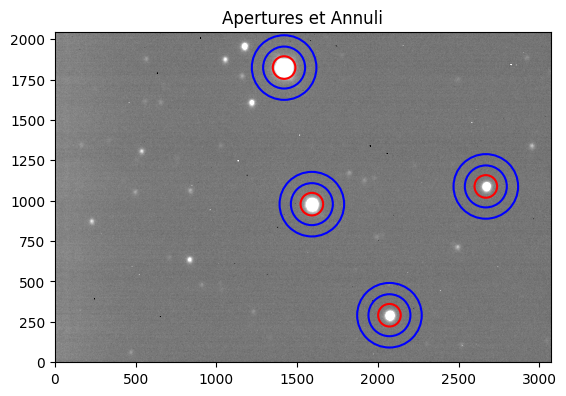

In [46]:
## Determiner aperture et annulus
# Positions des étoiles détectées
star_positions = star_positions[:4]

# Définir l'aperture pour chaque étoile
aperture_radius = 70  # Rayon de l'aperture en pixels
apertures = CircularAperture(star_positions, r=aperture_radius)

# Définir un annulus pour chaque étoile pour estimer le fond
annulus_inner_radius = 130  # Rayon interne de l'annulus
annulus_outer_radius = 200  # Rayon externe de l'annulus
annuli = CircularAnnulus(star_positions, r_in=annulus_inner_radius, r_out=annulus_outer_radius)

# Tracer les apertures et les annuli sur l'image
plt.figure()
plt.imshow(image_data, origin='lower', vmin=z1, vmax=z2, cmap='gray')
apertures.plot(color='red', lw=1.5)
annuli.plot(color='blue', lw=1.5)
plt.title('Apertures et Annuli')
plt.show()

In [47]:
pos=star_positions
print(pos)
# Coordonnées de l'étoile cible et des étoiles de référence
star_positions = [pos[0],pos[2],pos[3]]
target_position = pos[1]

[[1419.51962202 1824.88628461]
 [1591.29726151  978.88315028]
 [2071.84318075  290.93784869]
 [2668.77788603 1088.65374983]]


Traitement du fichier : E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_primaire/obs_pri-0001r.fit
2460578.5925578703
Traitement du fichier : E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_primaire/obs_pri-0002r.fit
2460578.592780671
Traitement du fichier : E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_primaire/obs_pri-0003r.fit
2460578.5929987268
Traitement du fichier : E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_primaire/obs_pri-0004r.fit
2460578.5932131945
Traitement du fichier : E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_primaire/obs_pri-0005r.fit
2460578.5934277778
Traitement du fichier : E:/Documents/Cours_et_administratif/FAC/Master/M2/ohp/data/2024-09-24-lyon-mtp_c/observation_primaire/obs_pri-0006r.fit
2460578.5936561343
Traitement du fichier :

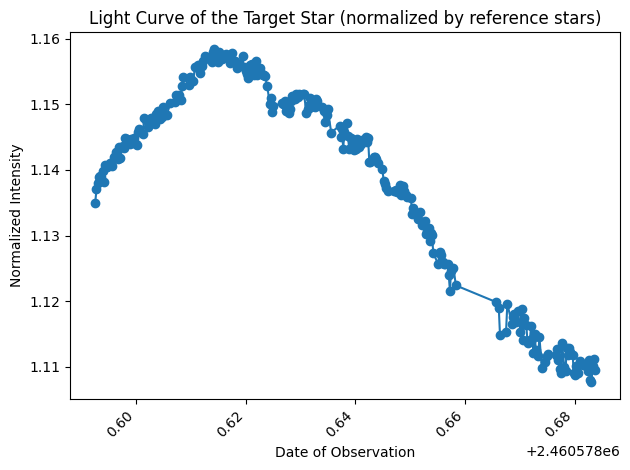

In [48]:
from astropy.time import Time

# Initialiser des listes pour stocker les résultats d'intensité et les dates d'observation
target_intensities = []
reference_intensities = []
observation_dates = []  # Pour stocker les dates d'observation

# Parcourir les fichiers d'observation
for fits_file in fits_files:
    print(f"Traitement du fichier : {fits_file}")
    
    # Charger l'image CCD et extraire la date d'observation
    with fits.open(fits_file) as hdu:
        header = hdu[0].header
        date_obs = header.get('DATE-OBS', None)  # Récupérer la date d'observation
        if date_obs is not None:
            observation_dates.append(Time(date_obs).jd)  # Convertir en format ISO et ajouter à la liste
        print(Time(date_obs).jd)
        ccd_sci = CCDData(hdu[0].data, unit='adu')  # Charger les données CCD
    
    # Photométrie pour l'étoile cible
    target_aperture = CircularAperture(target_position, r=aperture_radius)
    target_annulus = CircularAnnulus(target_position, r_in=annulus_inner_radius, r_out=annulus_outer_radius)
    
    # Photométrie pour les étoiles de référence
    reference_apertures = CircularAperture(star_positions, r=aperture_radius)
    reference_annuli = CircularAnnulus(star_positions, r_in=annulus_inner_radius, r_out=annulus_outer_radius)
    
    # Calculer les intensités avec photométrie d'aperture
    phot_table_target = aperture_photometry(ccd_sci.data, target_aperture)
    phot_table_ref = aperture_photometry(ccd_sci.data, reference_apertures)
    
    # Extraire la somme d'intensité pour l'étoile cible et les étoiles de référence
    target_intensity = phot_table_target['aperture_sum'][0]
    reference_intensity = np.mean(phot_table_ref['aperture_sum'])  # Moyenne des intensités des étoiles de référence
    
    # Stocker les intensités
    target_intensities.append(target_intensity)
    reference_intensities.append(reference_intensity)

# Calculer la courbe de lumière normalisée
light_curve = np.array(target_intensities) / np.array(reference_intensities)

# Afficher la courbe de lumière avec la date d'observation sur l'axe des x
plt.figure()
plt.plot(observation_dates, light_curve, marker='o')
plt.xticks(rotation=45, ha='right')  # Tourner les étiquettes des dates pour une meilleure lisibilité
plt.xlabel('Date of Observation')
plt.ylabel('Normalized Intensity')
plt.title('Light Curve of the Target Star (normalized by reference stars)')
plt.tight_layout()  # Pour éviter les chevauchements
plt.show()
